#SRGAN


##Install libraries

In [ ]:
%%capture
!pip install tensorflow keras opencv-python matplotlib numpy tqdm

##Import libraries


In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import requests
import tensorflow_datasets as tfds
import tqdm
import os
import shutil
import re
import cv2
import time
import logging

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, LeakyReLU, Add, PReLU, Flatten
from keras.layers import UpSampling2D, LeakyReLU, Dense, Input, add, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import numpy as np

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


##Load data

In [ ]:
# #specify the path to the video folder and the image folder
video_dir = 'PATH/TO/VIDEOS'
image_dir = 'PATH/TO/IMAGES'

In [ ]:
# #Read all the videos from the folder
video_files = [f for f in os.listdir(video_dir) if f.endswith('.mp4') or f.endswith('.avi')]

In [ ]:
# #Iterate over each video file in the directory
for video_file in video_files:
    video_path = os.path.join(video_dir, video_file)
    vidcap = cv2.VideoCapture(video_path)   #Read the video

    def getFrame(sec):
        vidcap.set(cv2.CAP_PROP_POS_MSEC, sec*1000)  #we set the video capture object to the desired frame
        hasFrames, image = vidcap.read() #read the frame

        if hasFrames:  #if there is frame then save it as an image
            cv2.imwrite(os.path.join(image_dir, "image"+str(count)+".jpg"), image)

        return hasFrames #return whether there are more frames

    sec = 0
    frame_rate = 0.5  # this will capture an image every 0.5 seconds
    count = 1
    success = getFrame(sec)
    while success:
        count = count + 1
        sec = sec + frame_rate
        sec = round(sec, 2)
        success = getFrame(sec)

In [ ]:
dir_path= 'PATH/TO/DIRECTORY'
data = tf.keras.utils.image_dataset_from_directory(dir_path, labels=None)

Found 56 files belonging to 1 classes.


##Data processing

In [ ]:
train_size = int(len(data)*.7)
test_size = len(data)-train_size

In [ ]:
train_data = data.take(train_size)
test_data = data.skip(train_size).take(test_size)

In [ ]:
train_lr = []
train_hr = []
test_lr = []
test_hr = []

In [ ]:
def build_and_interpolate_data(image):
    cropped = tf.image.random_crop(image / 255, (100, 100, 3))
    lr = tf.image.resize(cropped, (25, 25))
    bicubic_resized = tf.image.resize(lr, (100, 100), method=tf.image.ResizeMethod.BICUBIC)
    return lr, bicubic_resized, cropped

In [ ]:
# Process the training data
for images in train_data:
    for image in images:
        lr, bicubic_resized, cropped = build_and_interpolate_data(image)
        train_lr.append(lr)
        train_hr.append(cropped)

In [ ]:
# Process the testing data
for images in test_data:
    for image in images:
        lr, bicubic_resized, cropped = build_and_interpolate_data(image)
        test_lr.append(lr)
        test_hr.append(cropped)

In [ ]:
# Convert the lists to NumPy arrays
train_lr = np.array(train_lr)
train_hr = np.array(train_hr)
test_lr = np.array(test_lr)
test_hr = np.array(test_hr)

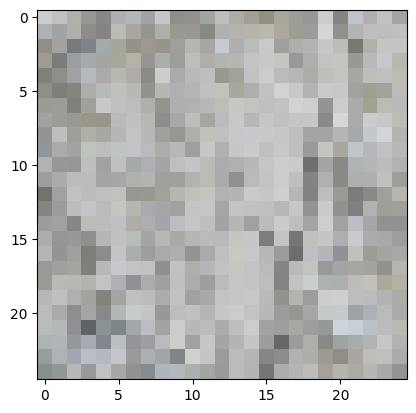

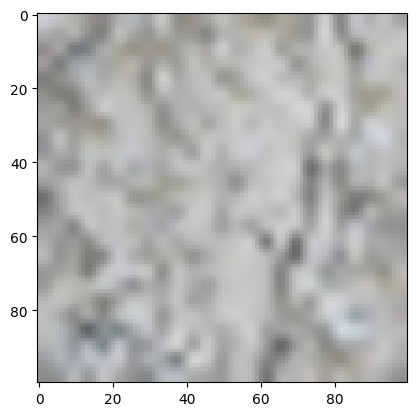

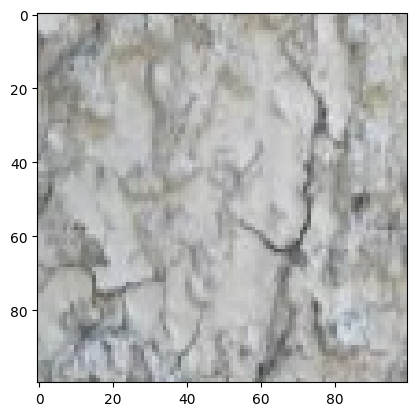

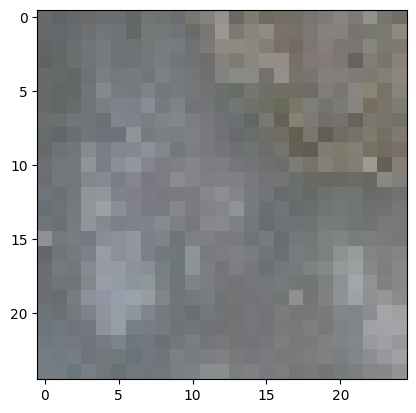

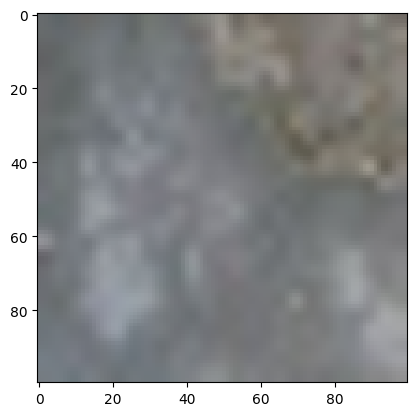

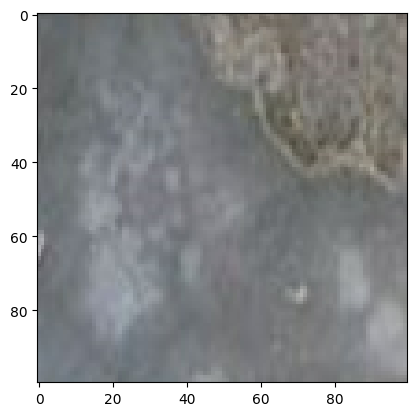

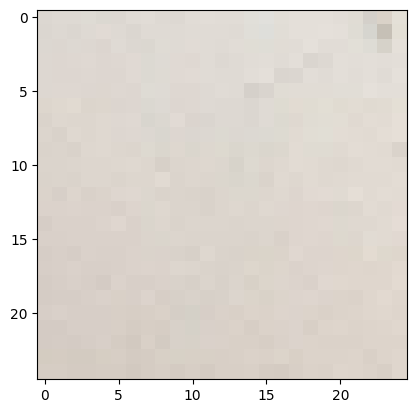

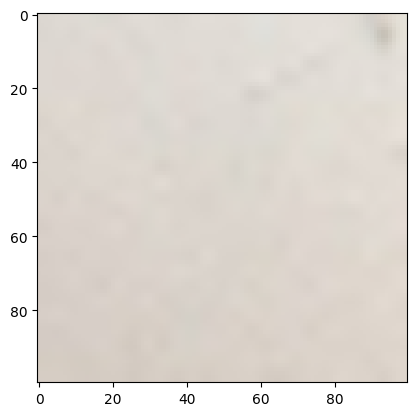

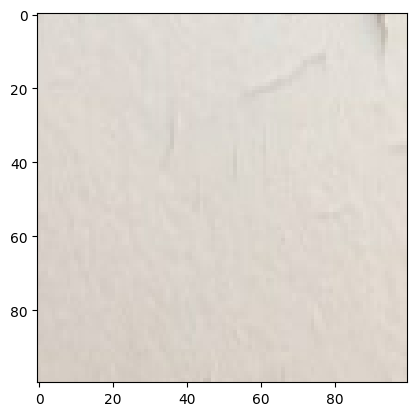

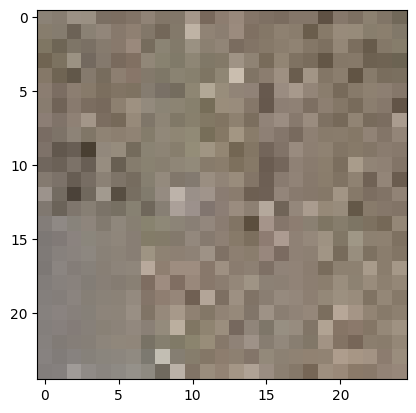

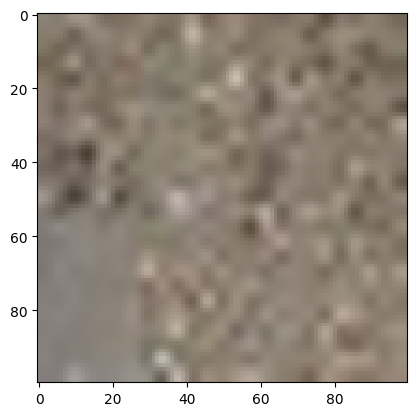

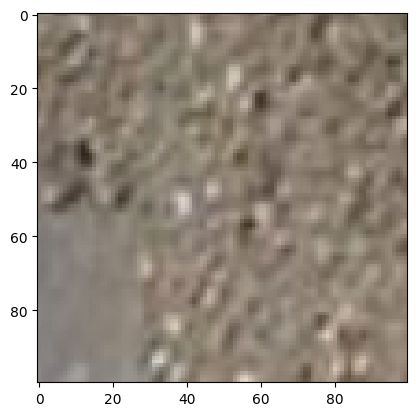

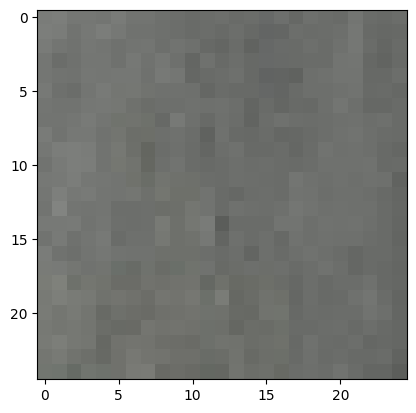

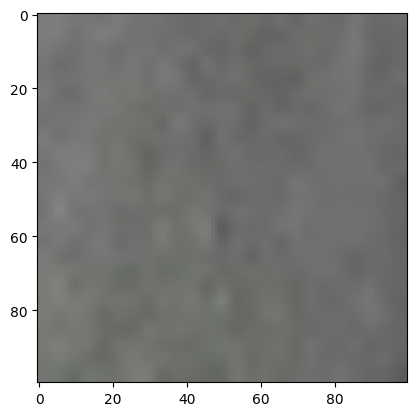

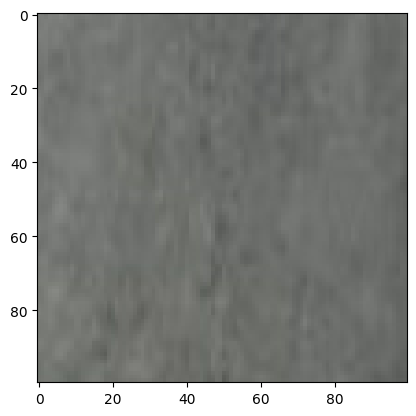

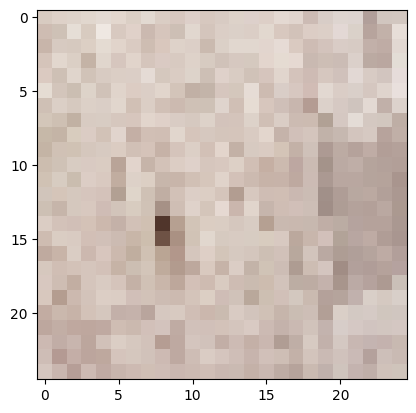

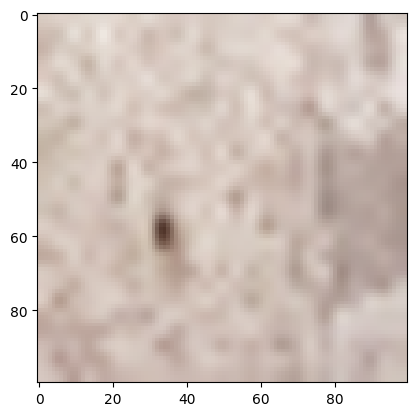

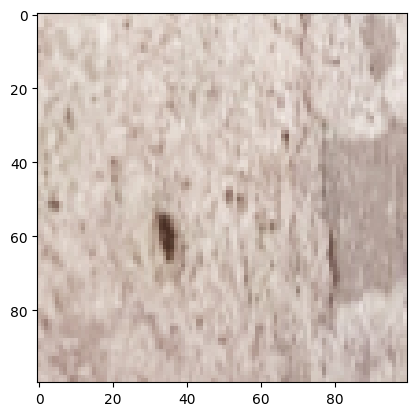

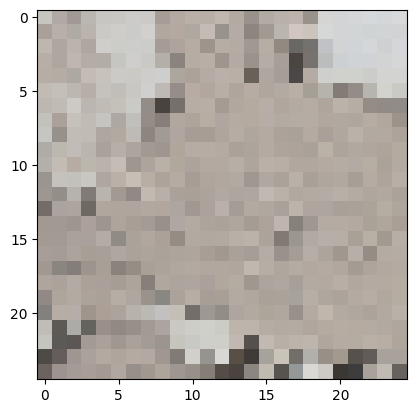

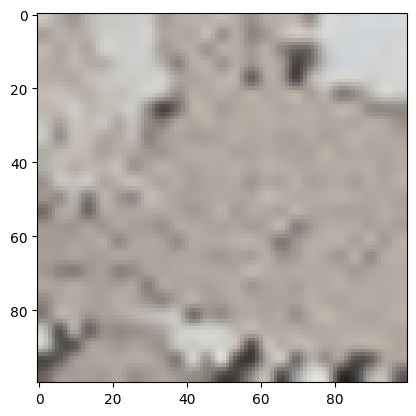

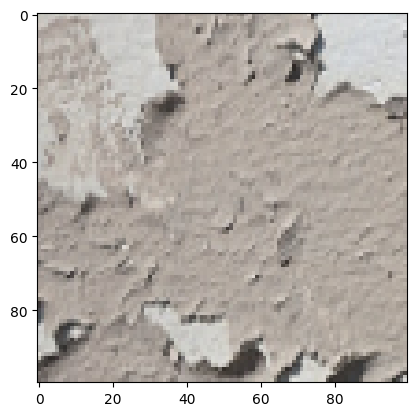

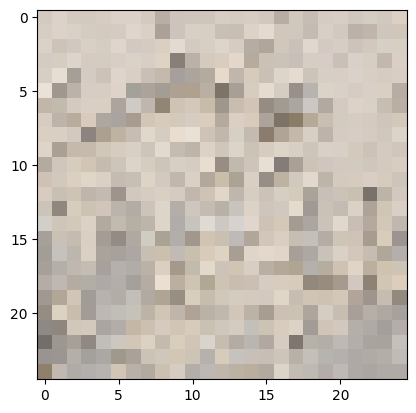

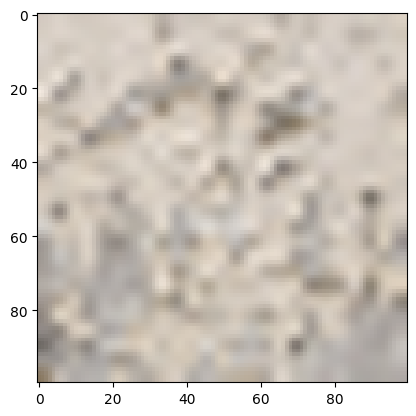

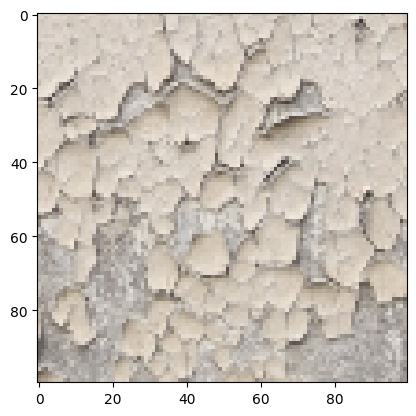

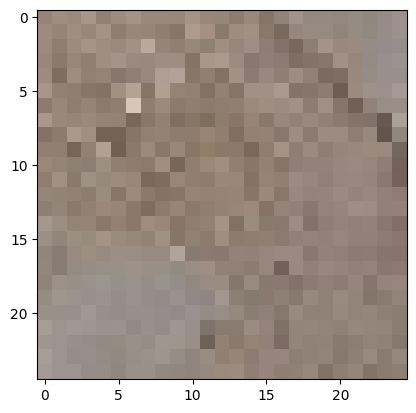

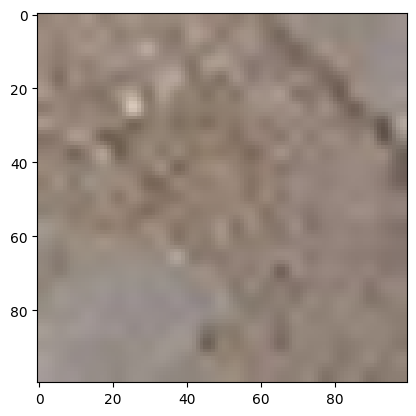

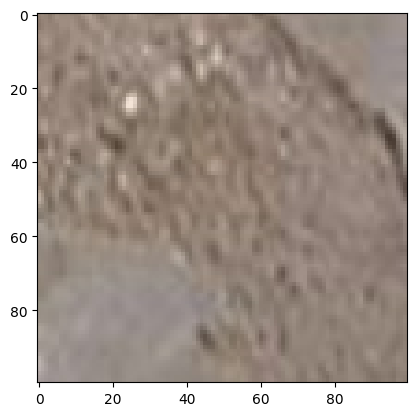

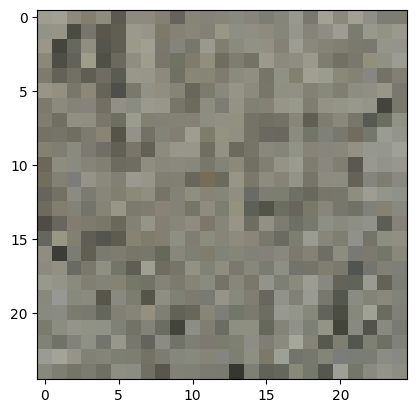

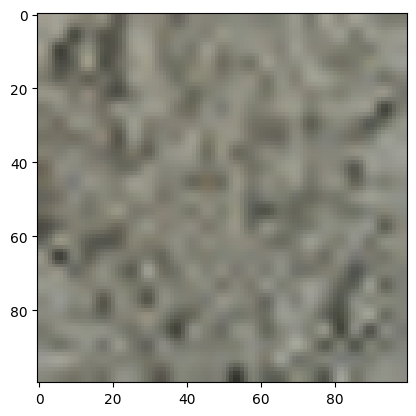

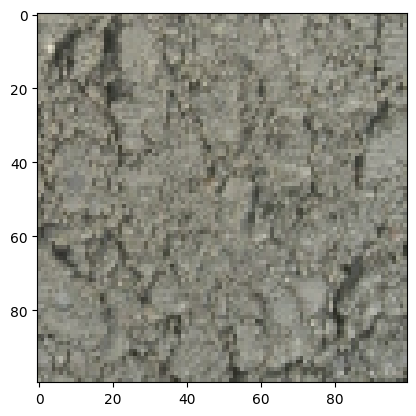

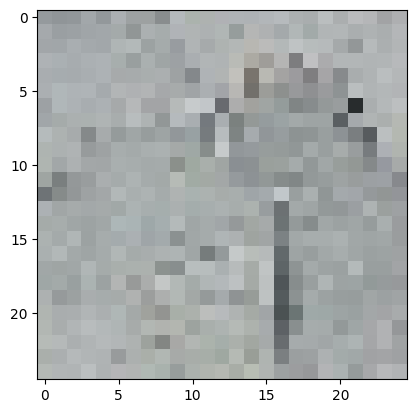

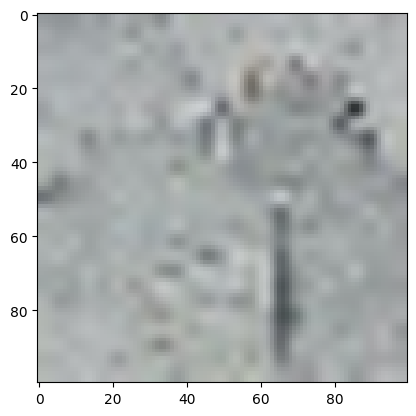

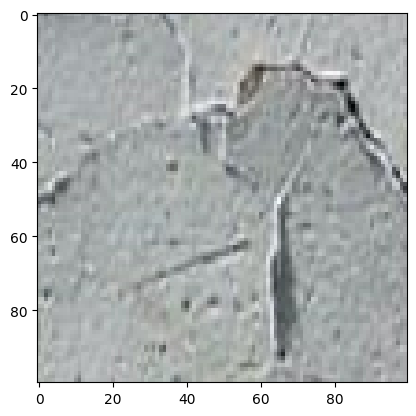

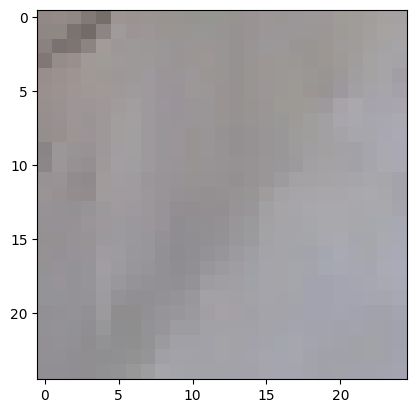

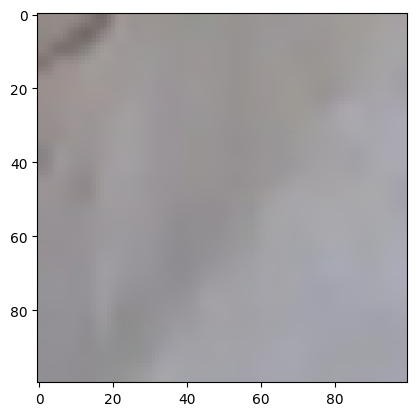

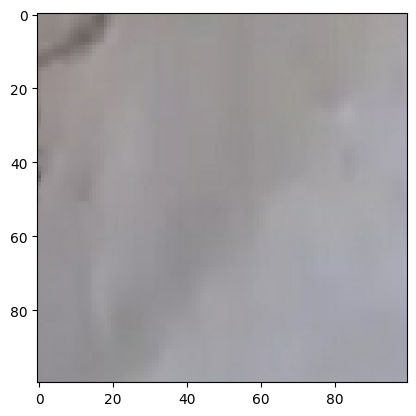

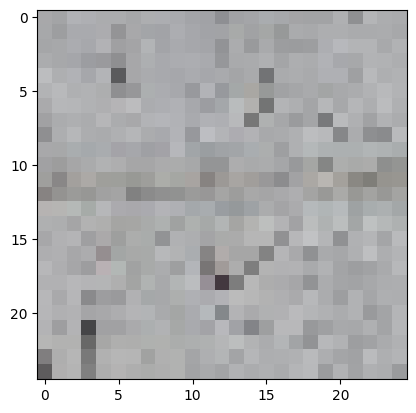

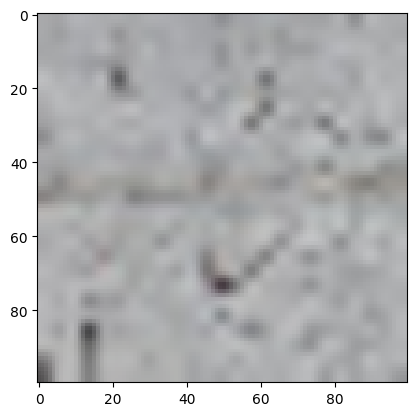

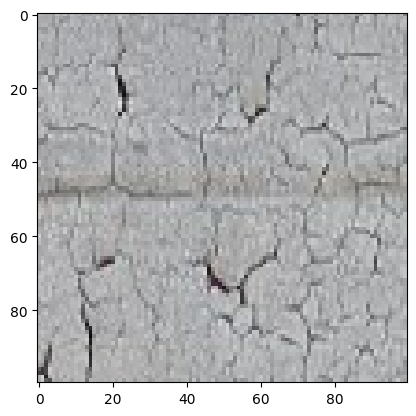

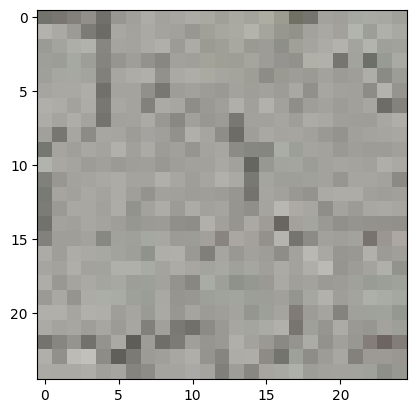

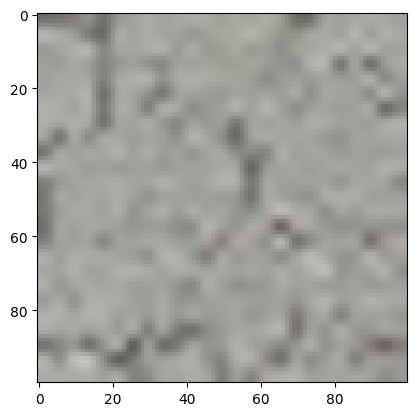

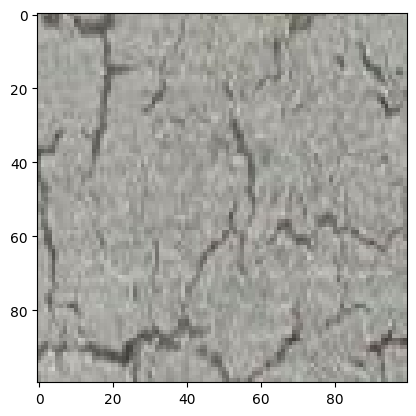

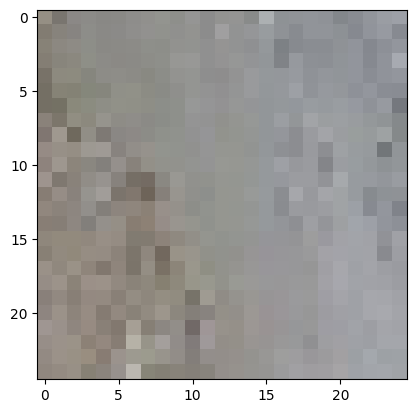

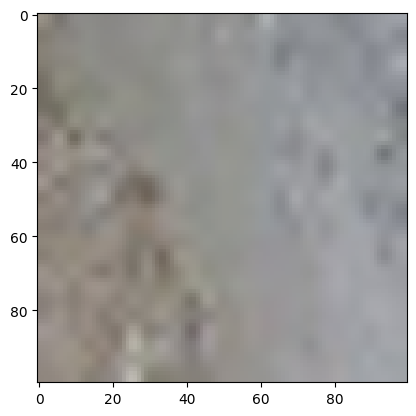

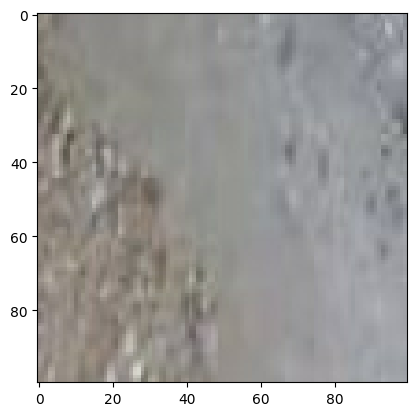

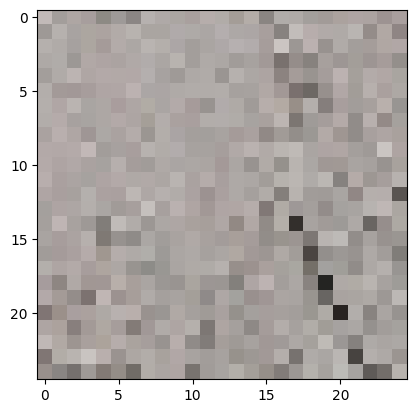

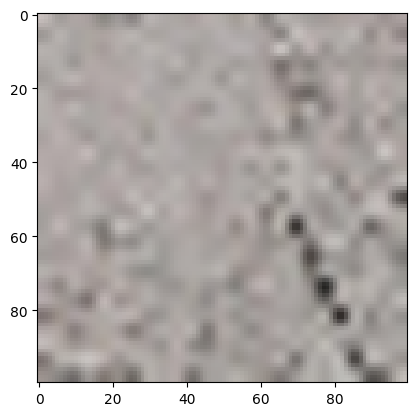

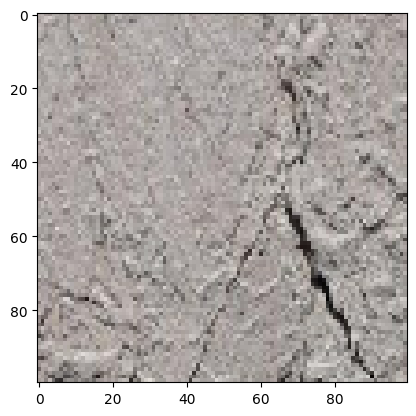

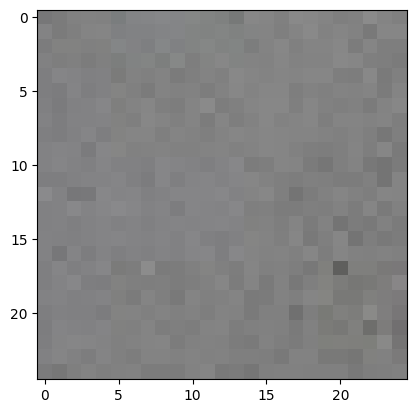

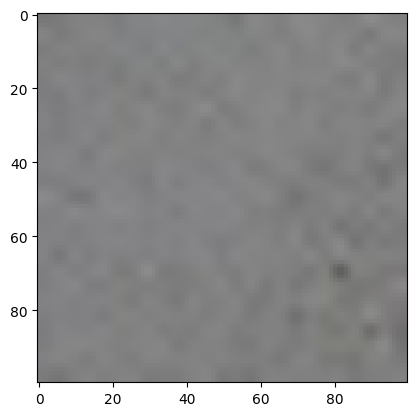

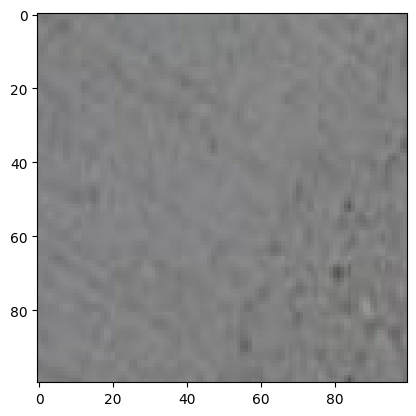

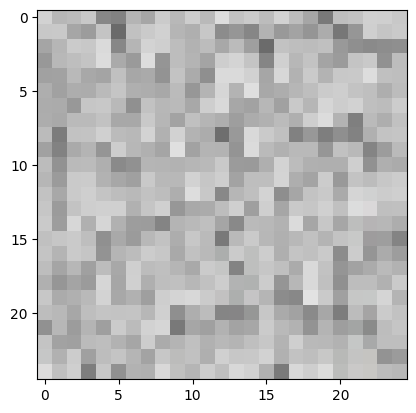

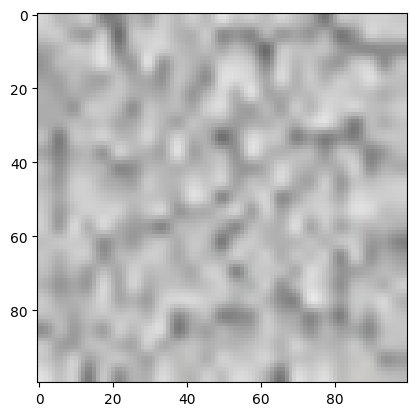

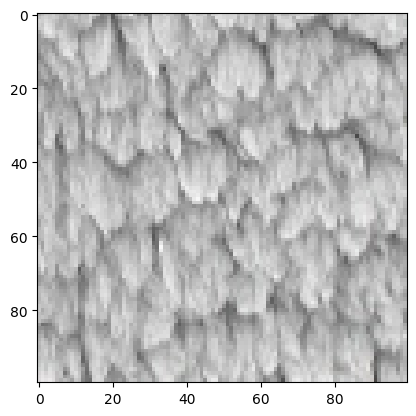

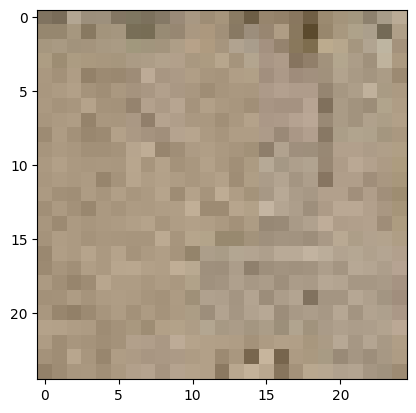

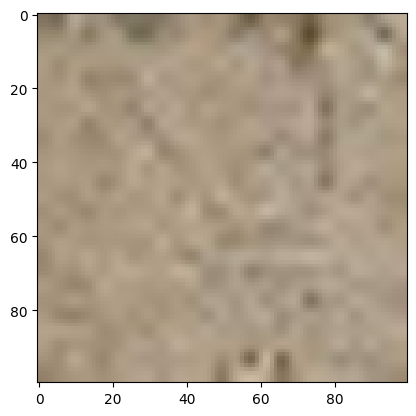

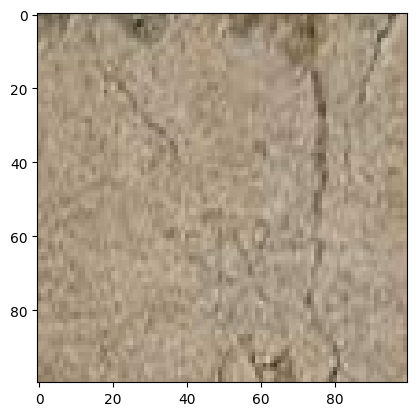

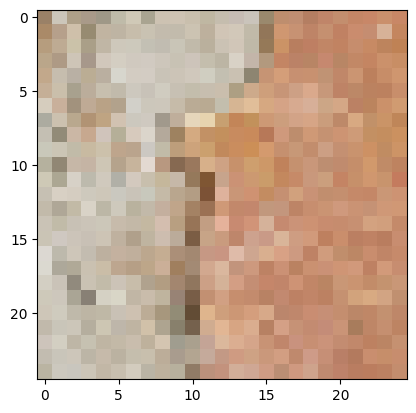

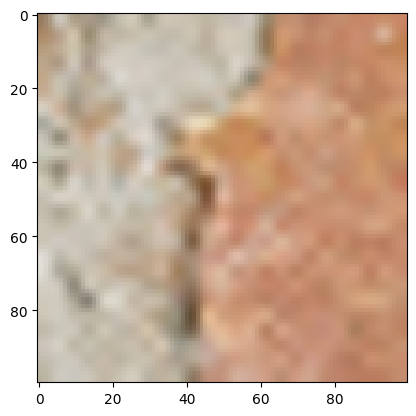

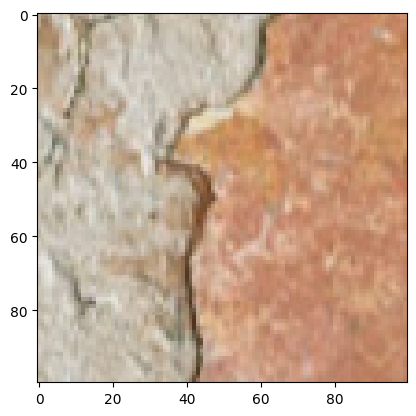

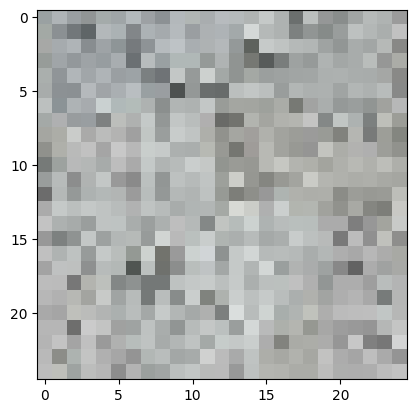

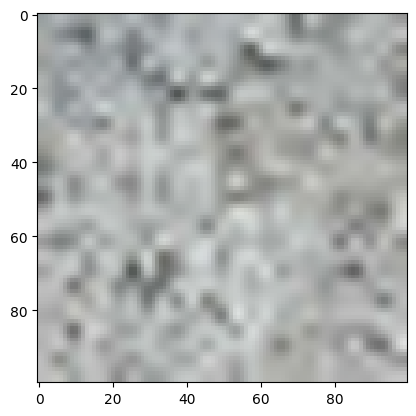

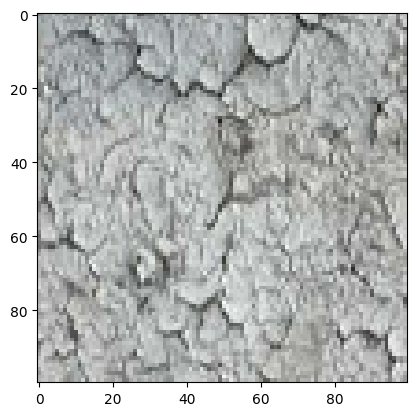

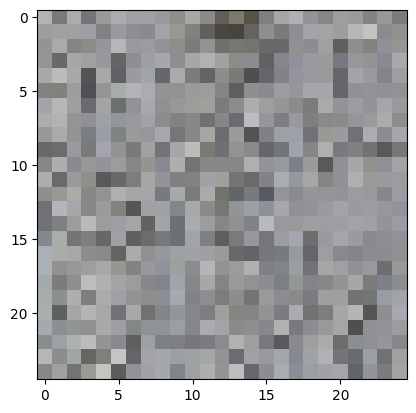

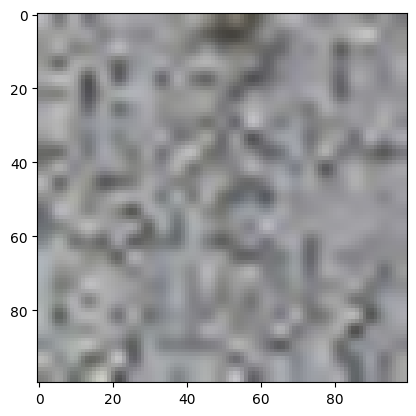

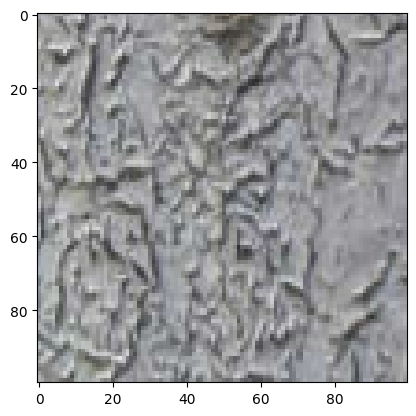

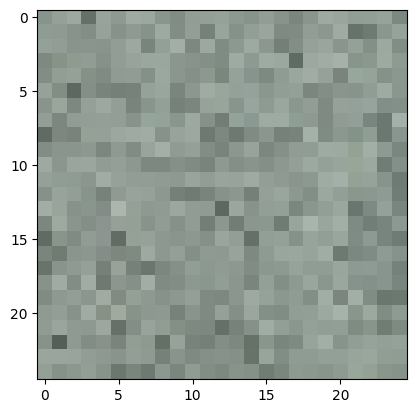

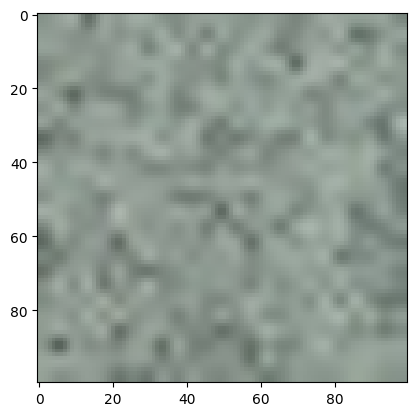

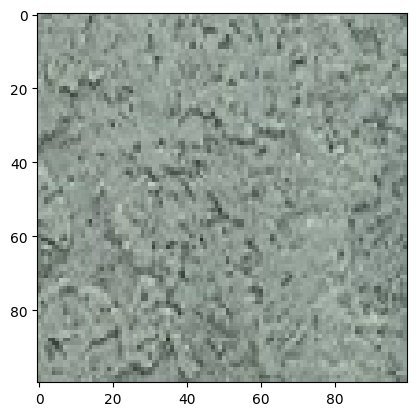

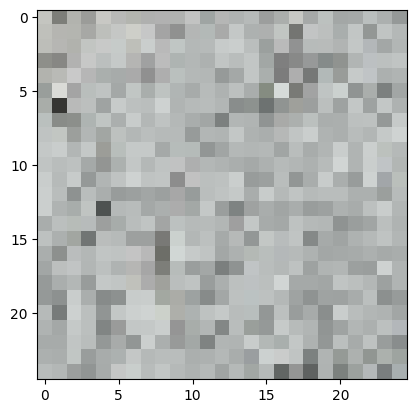

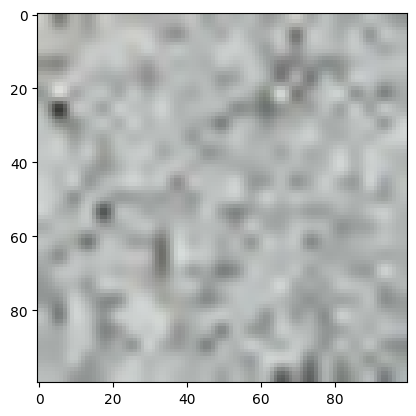

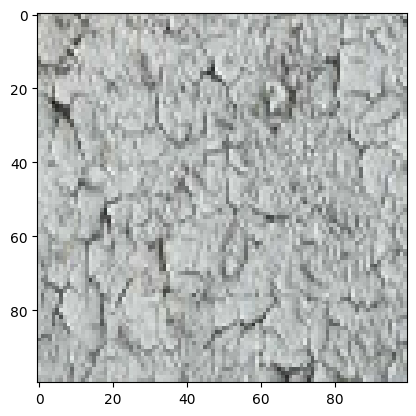

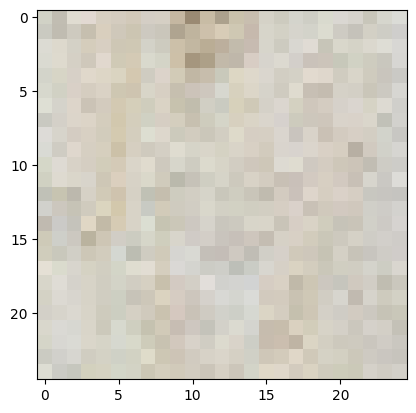

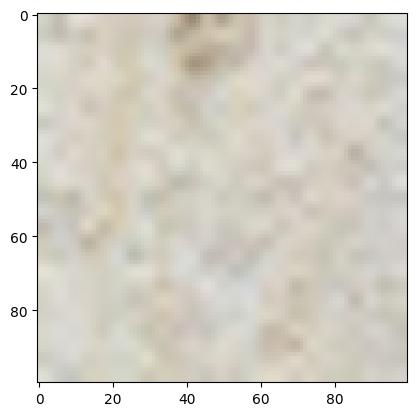

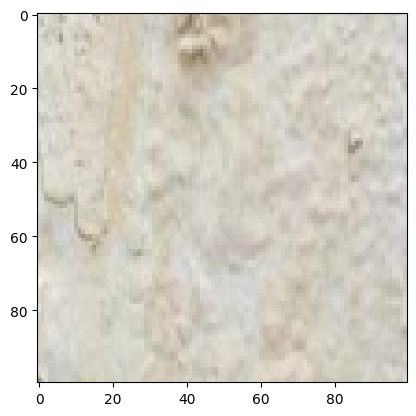

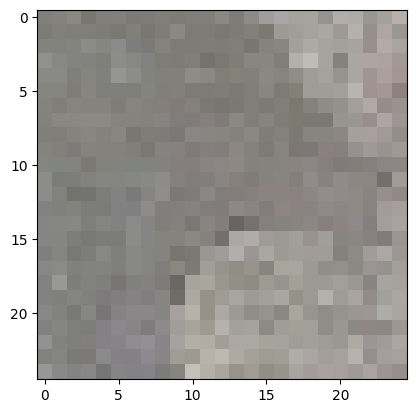

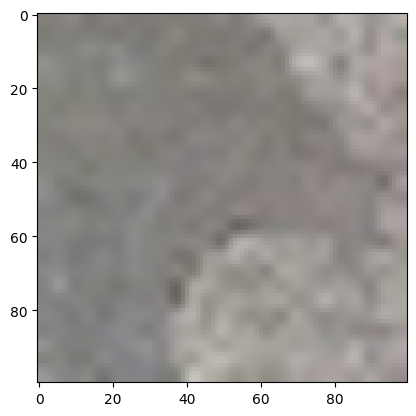

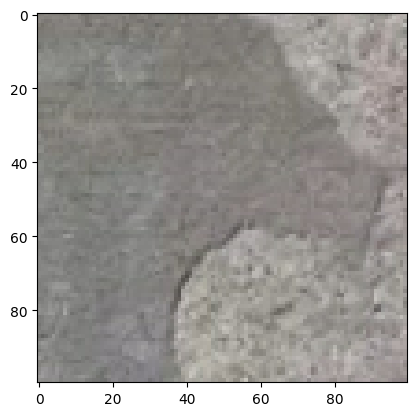

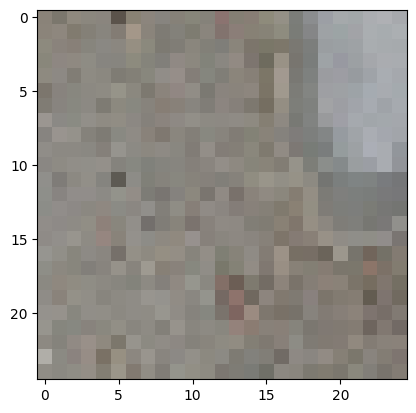

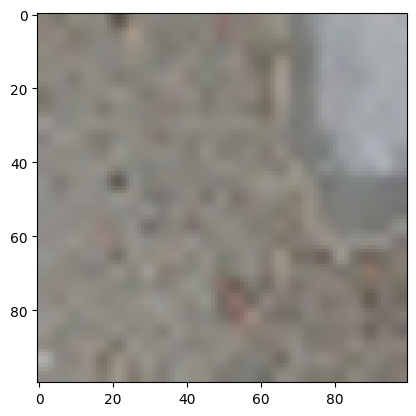

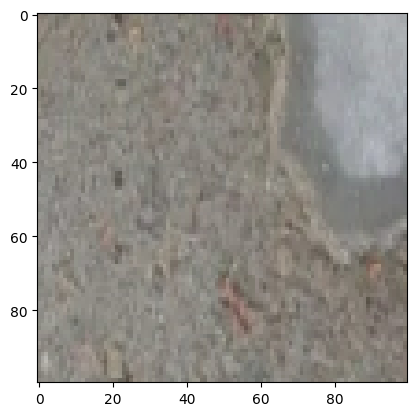

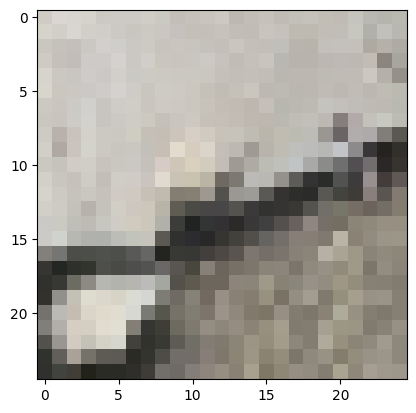

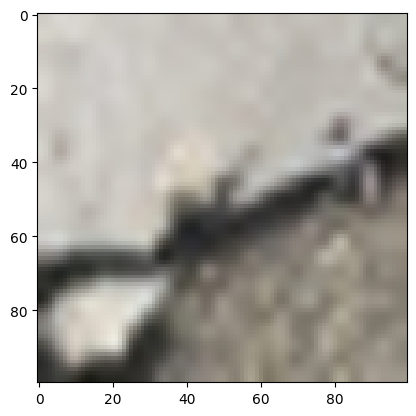

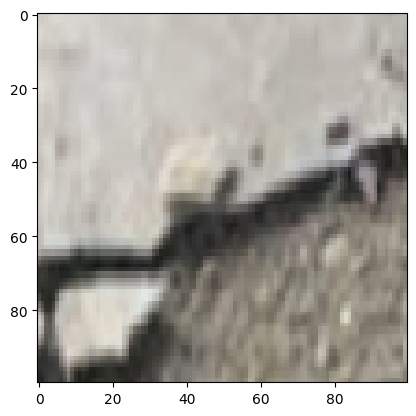

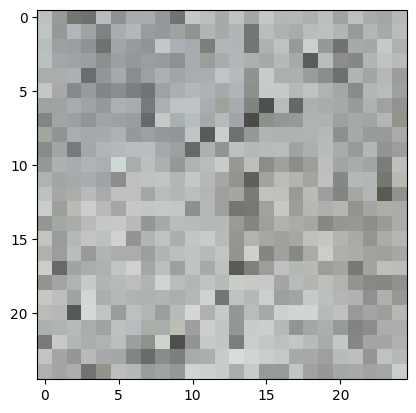

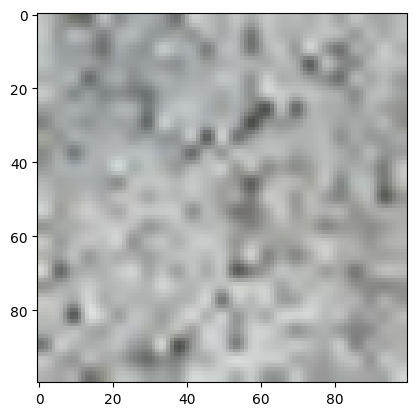

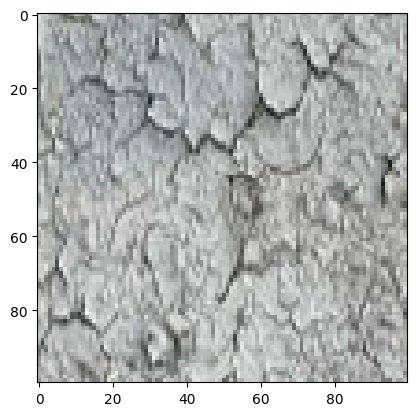

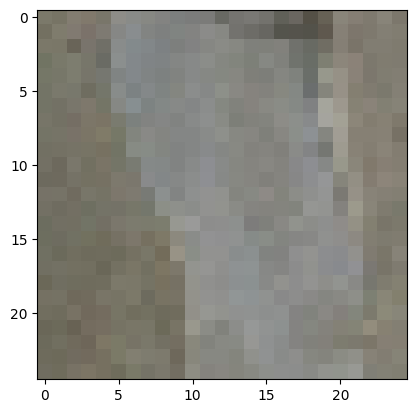

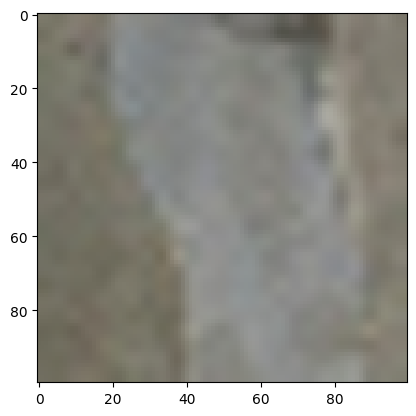

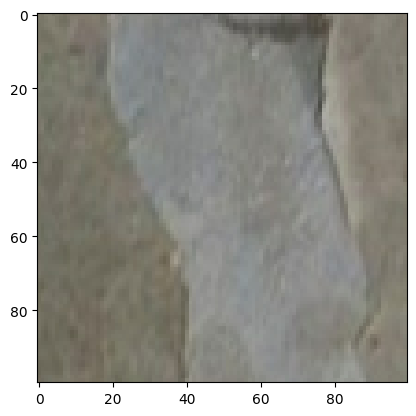

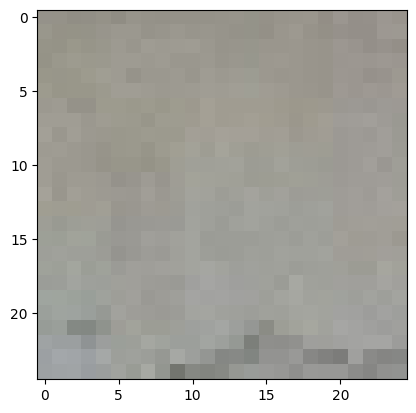

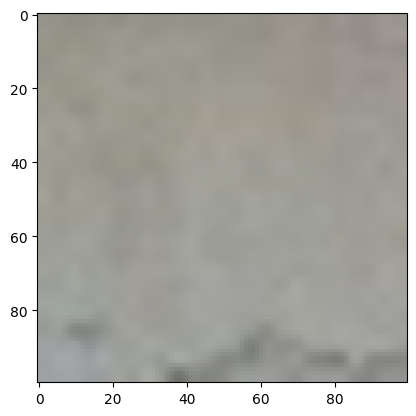

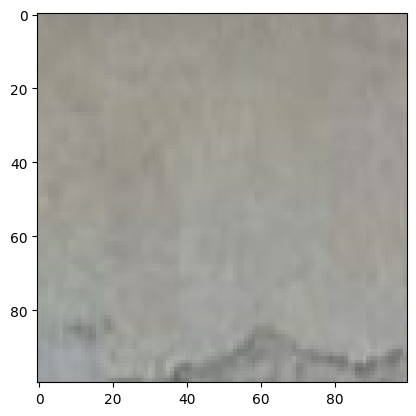

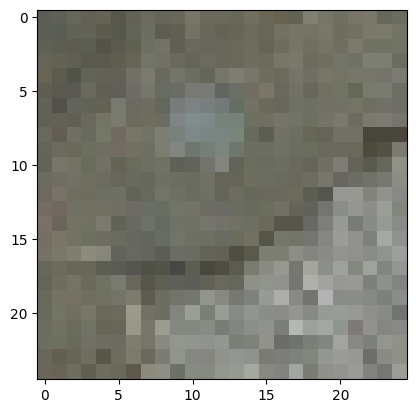

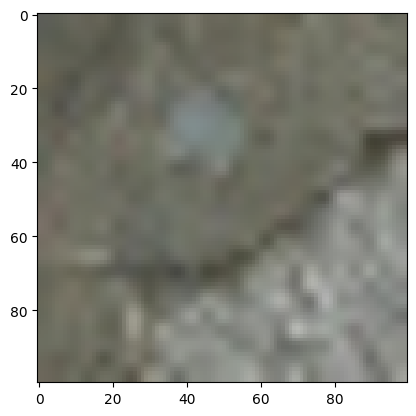

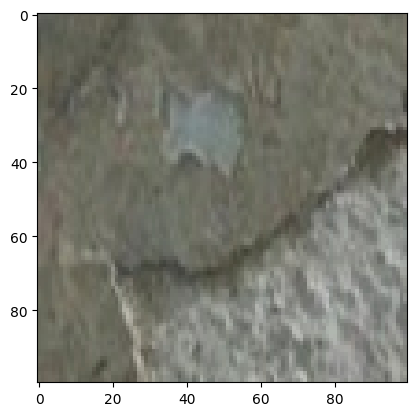

In [ ]:
# Iterate through the training data and apply the function
for images in train_data.take(1): # Take only 1 batch
    for image in images:
        lr, bicubic_resized, cropped = build_and_interpolate_data(image)
        plt.imshow(lr.numpy())
        plt.show()
        plt.imshow(bicubic_resized.numpy())
        plt.show()
        plt.imshow(cropped.numpy())
        plt.show()

In [ ]:
lr_input = Input(shape=(25,25,3))
hr_input = Input(shape=(100,100,3))

In [ ]:
hr_shape = hr_input.shape[1:]
print(hr_shape)

(100, 100, 3)


In [ ]:
test_lr.shape

(24, 25, 25, 3)

In [ ]:
test_hr.shape

(24, 100, 100, 3)

##Define Generator

In [ ]:
# Residual block
def residual_block_generator(input):
    x = Conv2D(64, (3,3), padding = "same")(input)
    x = BatchNormalization(momentum = 0.5)(x)
    x = PReLU(shared_axes = [1,2])(x)
    x = Conv2D(64, (3,3), padding = "same")(x)
    x = BatchNormalization(momentum = 0.5)(x)
    return add([input,x])

In [ ]:
# Upscale the image 2x
def upscale_block(input):
    u = Conv2D(256, (3,3), padding="same")(input)
    u = UpSampling2D( size = 2 )(u)
    u = PReLU(shared_axes=[1,2])(u)
    return u

In [ ]:
n_res_conv_block = 16

In [ ]:
# Generator Model
def create_generator(generator_input):
    x = Conv2D(64, (9,9), padding="same")(generator_input)
    x = PReLU(shared_axes=[1,2])(x)
    temp = x
    for i in range(n_res_conv_block):
        x = residual_block_generator(x)
    x = Conv2D(64, (3,3), padding="same")(x)
    x = BatchNormalization(momentum=0.5)(x)
    x = add([x,temp])
    x = upscale_block(x)
    x = upscale_block(x)
    out = Conv2D(3, (9,9), padding="same")(x)
    return Model(inputs=generator_input, outputs=out)

##Define Discriminator

In [ ]:
# Residual block
def residual_block_discriminator(input, filters, strides=1, bn=True): #bn - batch normalization
  x = Conv2D(filters,(3,3), strides, padding ='same') (input)
  x = LeakyReLU(alpha=0.2)(x)
  if bn:
    x =  x = BatchNormalization(momentum=0.8)(x)
  return x

In [ ]:
#Build a Discriminator
def create_discriminator(input):
    f=64 #number of filters
    d1 = residual_block_discriminator(input, f, bn=False)
    d2 = residual_block_discriminator(d1, f, strides=2)
    d3 = residual_block_discriminator(d2, f*2)
    d4 = residual_block_discriminator(d3,f*2, strides=2)
    d5 = residual_block_discriminator(d4, f*4)
    d6 = residual_block_discriminator(d5, f*4, strides=2)
    d7 = residual_block_discriminator(d6, f*8)
    d8 = residual_block_discriminator(d7, f*8, strides=2)
    flatten = Flatten()(d8)
    d9 = Dense(f*16)(flatten)
    d10 = LeakyReLU(alpha=0.2)(d9)
    validity = Dense(1, activation='sigmoid')(d10)
    return Model(input, validity)

##VGG16 model

In [ ]:
from keras.applications import VGG19

In [ ]:
from keras.applications import VGG19
def build_vgg():
    base_vgg = VGG19(weights="imagenet", include_top=False, input_shape=hr_shape)
    vgg_output = base_vgg.layers[9].output
    return Model(base_vgg.input, vgg_output)

##Combined model

In [ ]:
# Attach the generator and discriminator
def combined_model(gen_model, disc_model, vgg, lr_input, hr_input):
    gen_img = gen_model(lr_input)
    gen_features = vgg(gen_img)
    disc_model.trainable = False
    validity = disc_model(gen_img)
    return Model([lr_input, hr_input],[validity,gen_features])

##Declare models

In [ ]:
generator = create_generator(lr_input)
discriminator = create_discriminator(hr_input)

In [ ]:
discriminator.compile(loss="binary_crossentropy", optimizer="adam",
  metrics=['accuracy'])

In [ ]:
vgg = build_vgg()
vgg.trainable = False

80134624/80134624 [==============================] - 5s 0us/step


In [ ]:
gan_model = combined_model(generator, discriminator, vgg, lr_input, hr_input)

In [ ]:
gan_model.compile(loss=["binary_crossentropy","mse"], loss_weights=
  [1e-3, 1], optimizer="adam")

##Sample the training data into small batches

In [ ]:
train_lr_batches = []
train_hr_batches = []

In [ ]:
batch_size = 32

In [ ]:
for it in range(int(train_hr.shape[0] / batch_size)):
    start_idx = it * batch_size
    end_idx = start_idx + batch_size
    train_hr_batches.append(train_hr[start_idx:end_idx])
    train_lr_batches.append(train_lr[start_idx:end_idx])
train_lr_batches = np.array(train_lr_batches)
train_hr_batches = np.array(train_hr_batches)

In [ ]:
train_lr_batches.shape

(1, 32, 25, 25, 3)

In [ ]:
train_hr_batches.shape

(1, 32, 100, 100, 3)

##Training the model

In [ ]:
epochs = 100

In [ ]:
fake_label = np.zeros((batch_size, 1))
real_label = np.ones((batch_size,1))

In [ ]:
for epoch in range(epochs):
    print(f"Epoch {epoch + 1}/{epochs}")

    for batch_index in range(len(train_hr_batches)):
        # Real and high-resolution images
        hr_imgs = train_hr_batches[batch_index]
        lr_imgs = train_lr_batches[batch_index]

        # Generate low-resolution images
        gen_imgs = generator.predict_on_batch(lr_imgs)


        # Train the discriminator
        discriminator.trainable = True
        d_loss_real = discriminator.train_on_batch(hr_imgs, real_label)
        d_loss_fake = discriminator.train_on_batch(gen_imgs, fake_label)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)


        # Train the generator
        discriminator.trainable = False
        image_features = vgg.predict(hr_imgs)
        g_loss, _, _ = gan_model.train_on_batch([lr_imgs, hr_imgs], [real_label, image_features])

        print(f"Batch {batch_index + 1}/{len(train_hr_batches)} - D Loss: {d_loss[0]} - G Loss: {g_loss}")

    print("---------------------------------------------------------")

Epoch 1/100
1/1 [==============================] - 1s 1s/step
Batch 1/1 - D Loss: 25.80888843536377 - G Loss: 90.58441925048828
---------------------------------------------------------
Epoch 2/100
1/1 [==============================] - 0s 20ms/step
Batch 1/1 - D Loss: 29.143091320991516 - G Loss: 161.58731079101562
---------------------------------------------------------
Epoch 3/100
1/1 [==============================] - 0s 20ms/step
Batch 1/1 - D Loss: 12.373375415802002 - G Loss: 103.18728637695312
---------------------------------------------------------
Epoch 4/100
1/1 [==============================] - 0s 19ms/step
Batch 1/1 - D Loss: 0.742585301399231 - G Loss: 29.15102195739746
---------------------------------------------------------
Epoch 5/100
1/1 [==============================] - 0s 19ms/step
Batch 1/1 - D Loss: 0.760996401309967 - G Loss: 23.12776756286621
---------------------------------------------------------
Epoch 6/100
1/1 [==============================] - 0s 19ms

In [ ]:
for e in range(epochs):
    gen_label = np.zeros((batch_size, 1))
    real_label = np.ones((batch_size,1))
    g_losses = []
    d_losses = []
    for b in range(len(train_hr_batches)):
        lr_imgs = train_lr_batches[b]
        hr_imgs = train_hr_batches[b]
        gen_imgs = generator.predict_on_batch(lr_imgs)
        #Dont forget to make the discriminator trainable
        discriminator.trainable = True

        #Train the discriminator
        d_loss_gen = discriminator.train_on_batch(gen_imgs,
          gen_label)
        d_loss_real = discriminator.train_on_batch(hr_imgs,
          real_label)
        discriminator.trainable = False
        d_loss = 0.5 * np.add(d_loss_gen, d_loss_real)
        image_features = vgg.predict(hr_imgs)

        #Train the generator
        g_loss, _, _ = gan_model.train_on_batch([lr_imgs, hr_imgs],
          [real_label, image_features])

        d_losses.append(d_loss)
        g_losses.append(g_loss)
    g_losses = np.array(g_losses)
    d_losses = np.array(d_losses)

    g_loss = np.sum(g_losses, axis=0) / len(g_losses)
    d_loss = np.sum(d_losses, axis=0) / len(d_losses)

    print(f"Batch {batch_index + 1}/{len(train_hr_batches)} - D Loss: {d_loss} - G Loss: {g_loss}")
    print("---------------------------------------------------------")

1/1 [==============================] - 0s 20ms/step
Batch 1/1 - D Loss: [0.00188377 1.        ] - G Loss: 6.368308067321777
---------------------------------------------------------
1/1 [==============================] - 0s 20ms/step
Batch 1/1 - D Loss: [0.01740667 1.        ] - G Loss: 6.33519172668457
---------------------------------------------------------
1/1 [==============================] - 0s 20ms/step
Batch 1/1 - D Loss: [0.37033899 0.890625  ] - G Loss: 6.345797061920166
---------------------------------------------------------
1/1 [==============================] - 0s 20ms/step
Batch 1/1 - D Loss: [0.41723621 0.921875  ] - G Loss: 6.199195861816406
---------------------------------------------------------
1/1 [==============================] - 0s 21ms/step
Batch 1/1 - D Loss: [0.23128299 0.9375    ] - G Loss: 6.271739482879639
---------------------------------------------------------
1/1 [==============================] - 0s 20ms/step
Batch 1/1 - D Loss: [0.0349942 1.      

##Evaluation

In [ ]:
test_hr.shape

(24, 100, 100, 3)

In [ ]:
label = np.ones((len(test_lr),1))
test_features = vgg.predict(test_hr)
eval,_,_ = gan_model.evaluate([test_lr, test_hr], [label,test_features])

1/1 [==============================] - 3s 3s/step - loss: 10.9741 - model_1_loss: 68.9648 - model_2_loss: 10.9052


In [ ]:
def evaluate_srgan(generator, discriminator, hr_test_images, lr_test_images):
    real_label = np.ones((len(hr_test_images), 1))
    fake_label = np.zeros((len(hr_test_images), 1))

    # Ensure the low-res images are 4-dimensional
    if len(lr_test_images.shape) == 3:
        lr_test_images = np.expand_dims(lr_test_images, axis=0)

    # Generate super-resolved images
    generated_images = generator.predict_on_batch(lr_test_images)

    # Evaluate discriminator
    d_loss_real = discriminator.evaluate(hr_test_images, real_label, verbose=0)
    d_loss_fake = discriminator.evaluate(generated_images, fake_label, verbose=0)
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

    print(f"Discriminator Loss: {d_loss[0]}")
    print(f"Discriminator Accuracy Real: {d_loss_real[1]}")
    print(f"Discriminator Accuracy Fake: {d_loss_fake[1]}")

    # Compute PSNR (Peak Signal to Noise Ratio) for generated images
    psnr_scores = [cv2.PSNR(hr_img, gen_img) for hr_img, gen_img in zip(hr_test_images, generated_images)]
    average_psnr = sum(psnr_scores) / len(psnr_scores)
    print(f"Average PSNR: {average_psnr} dB")

In [ ]:
evaluate_srgan(generator, discriminator, test_hr, test_lr)

Discriminator Loss: 94.05158996582031
Discriminator Accuracy Real: 0.8333333134651184
Discriminator Accuracy Fake: 0.625
Average PSNR: 62.310136684654935 dB


##Prediction

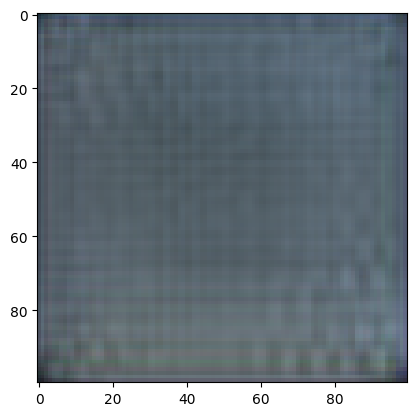

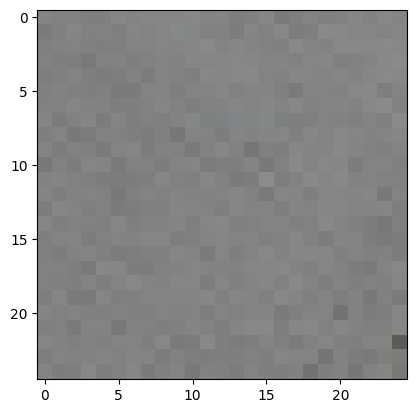

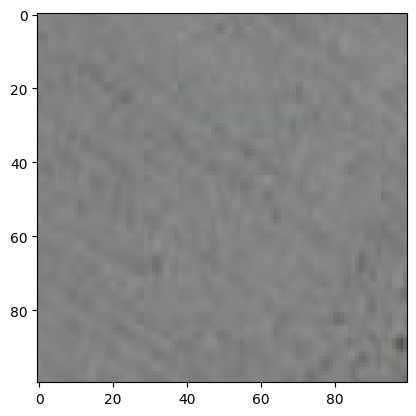

In [ ]:
test_prediction = generator.predict_on_batch(test_lr[:10])

plt.imshow(test_prediction[0])
plt.show()

plt.imshow(test_lr[0])
plt.show()

plt.imshow( test_hr[0])
plt.show()

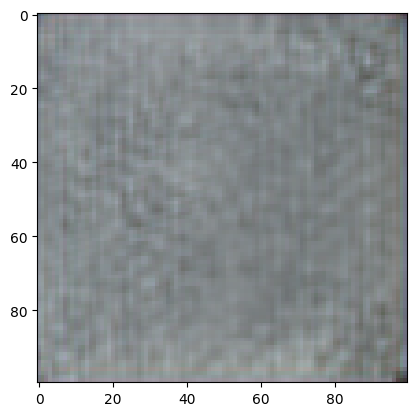

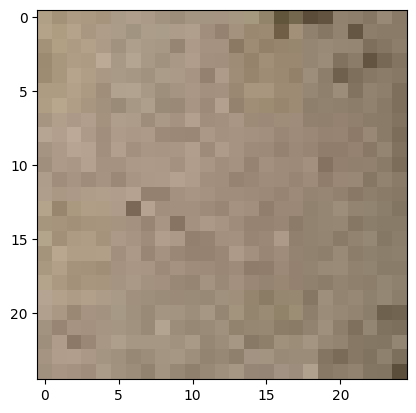

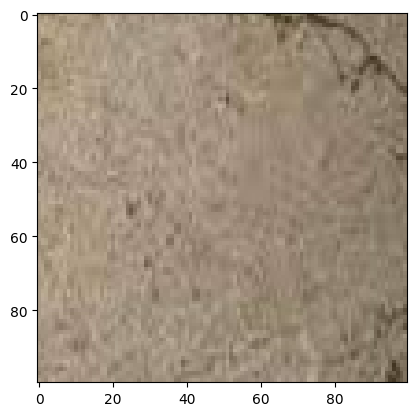

In [ ]:
res = generator.predict_on_batch(train_lr_batches[0])
plt.imshow(res[0])
plt.show()
plt.imshow(train_lr_batches[0][0])
plt.show()
plt.imshow(train_hr_batches[0][0])
plt.show()

In [ ]:
test_label = np.ones((len(test_lr),1))
test_imgs_features = vgg.predict(test_hr)
test_res = gan_model.evaluate([test_lr, test_hr], [test_label, test_imgs_features],10 )
print("Test loss & test Accuracy:", test_res)

3/3 [==============================] - 1s 265ms/step - loss: 9.1911 - model_24_loss: 2.7849 - model_25_loss: 9.1883
Test loss & test Accuracy: [9.191096305847168, 2.784902811050415, 9.188311576843262]


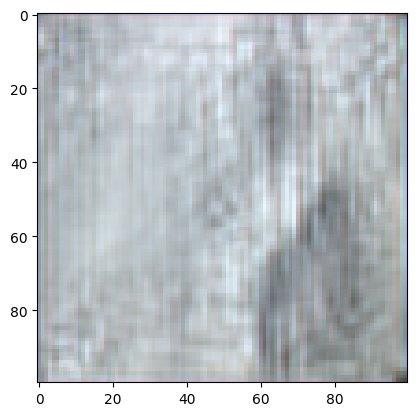

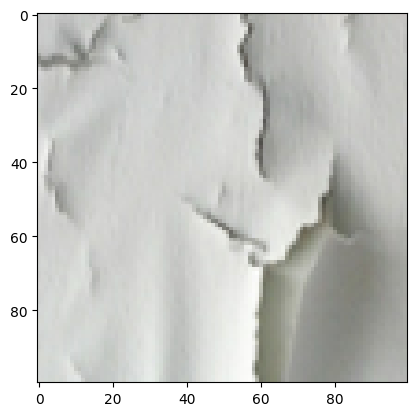

In [ ]:
test_gen = generator.predict_on_batch(test_lr)
plt.imshow(test_gen[10])
plt.show()
plt.imshow(test_hr[10])
plt.show()